In [ ]:
import sys
import os
import torch
from sklearn.metrics import r2_score
sys.path.insert(0, os.path.abspath(".."))  # Adds the parent directory to sys.path

from slim_gsgp.datasets.data_loader import load_pandas_df

from slim_gsgp.main_gp import gp  # import the slim_gsgp library
from slim_gsgp.datasets.data_loader import load_ppb, load_forest_fires, load_airfoil, load_parkinson_updrs  # import the loader for the dataset PPB
from slim_gsgp.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim_gsgp.utils.utils import train_test_split  # import the train-test split function

# Load the PPB dataset
X, y = load_ppb(X_y=True)
X,y = load_forest_fires(X_y=True)
X,y = load_airfoil(X_y=True)
X,y = load_parkinson_updrs(X_y=True)
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.3)

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.3)

# Apply the GP algorithm
final_tree1 = gp(X_train=X_train, y_train=y_train,
                X_test=X_val, y_test=y_val, p_xo = 0.2,
                dataset_name='ppb', pop_size=10, n_iter=50)

# Show the best individual structure at the last generation
final_tree1.print_tree_representation()

# Get the prediction of the best individual on the test set
predictions = final_tree1.predict(X_test)


print(r2_score(y_test, predictions))


Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     ppb                 |       0      |   29.882923126220703  |   30.104846954345703     |   0.05624961853027344  |      7           |
|     ppb                 |       1      |   29.882923126220703  |   30.104846954345703     |   0.004546642303466797 |      7           |
|     ppb                 |       2      |   29.882823944091797  |   30.104846954345703     |   0.004510402679443359 |      5           |
|     ppb                 |       3      |   29.882823944091797  |   30.104846954345703     |   0.0058078765869140625|      5           |
|     ppb        

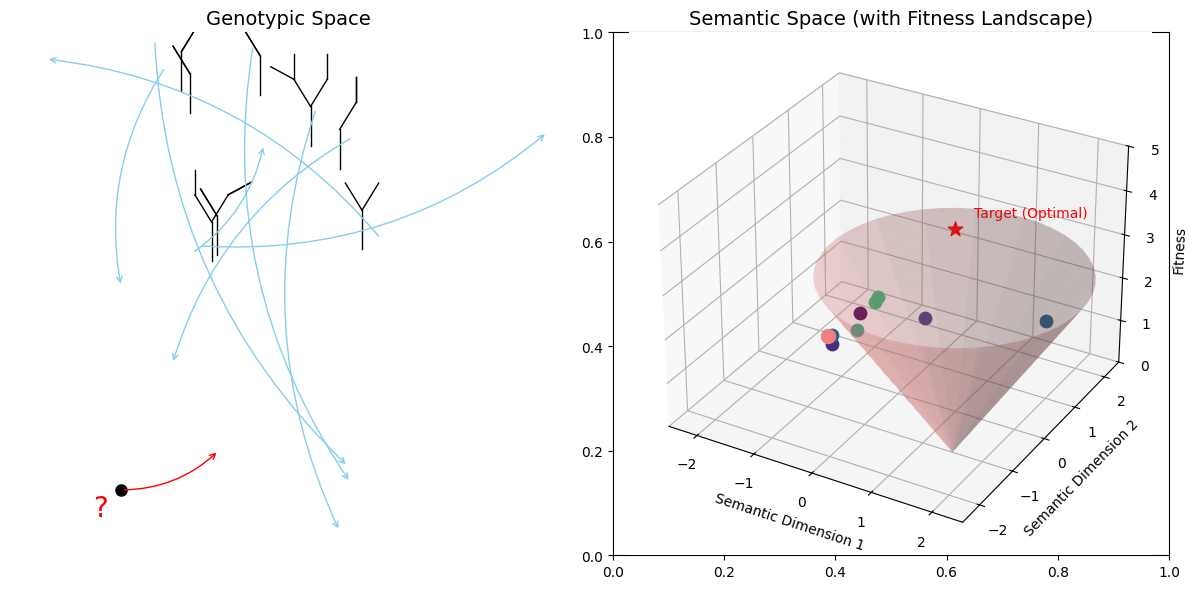

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# --- Define Data (More Abstract) ---
np.random.seed(42)

# Genotypic Space (Abstract Tree-like structures)
def draw_tree(ax, start_x, start_y, depth, scale=1, angle=90, branch_prob=0.7):
    if depth > 0:
        end_x = start_x + np.cos(np.deg2rad(angle)) * 0.5 * scale
        end_y = start_y + np.sin(np.deg2rad(angle)) * 0.5 * scale
        ax.plot([start_x, end_x], [start_y, end_y], 'k-', linewidth=1)
        if np.random.rand() < branch_prob:
            draw_tree(ax, end_x, end_y, depth - 1, scale * 0.8, angle + 30 * (1 if np.random.rand() < 0.5 else -1), branch_prob)
        draw_tree(ax, end_x, end_y, depth - 1, scale * 0.8, angle - 30 * (1 if np.random.rand() < 0.5 else -1), branch_prob)

genotypes = [(np.random.rand() * 2 - 1, np.random.rand() * 2) for _ in range(8)] # Simplified centers
tree_params = [(g[0] * 0.8, g[1] * 0.8, np.random.randint(2, 4)) for g in genotypes]

new_genotype_pos = (-1.2, -1.5)

# Semantic Space Data
semantic_points = np.random.rand(8, 2) * 4 - 2
target_point = (1.5, -1)
predicted_point = (-0.5, -1.2)

# --- Create the Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axes

# --- Genotypic Space ---
ax1.set_title("Genotypic Space", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.axis('off')

# Draw stylized trees
for x, y, depth in tree_params:
    draw_tree(ax1, x, y, depth, scale=0.6)

# New Genotype
ax1.text(new_genotype_pos[0] - 0.2, new_genotype_pos[1] - 0.2, "?", fontsize=20, color='red')
ax1.plot(new_genotype_pos[0], new_genotype_pos[1], 'ko', markersize=8)

# Mapping Arrows
for i, gp in enumerate(genotypes):
    ax1.annotate('', xy=semantic_points[i], xytext=gp,
                arrowprops=dict(arrowstyle='->', color='skyblue', lw=1, connectionstyle='arc3,rad=0.2'))
ax1.annotate('', xy=predicted_point, xytext=new_genotype_pos,
            arrowprops=dict(arrowstyle='->', color='red', lw=1, connectionstyle='arc3,rad=0.2'))

# --- Semantic Space with Fitness Landscape ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title("Semantic Space (with Fitness Landscape)", fontsize=14)
ax2.set_xlim([-2.5, 2.5])
ax2.set_ylim([-2.5, 2.5])
ax2.set_zlim([0, 5])
ax2.set_xlabel("Semantic Dimension 1")
ax2.set_ylabel("Semantic Dimension 2")
ax2.set_zlabel("Fitness")

# Cone for Fitness Landscape
radius = 2
height = 4
center_x, center_y = 1.5, -1  # Center around the target
num_steps = 50
theta = np.linspace(0, 2 * np.pi, num_steps)
z = np.linspace(0, height, num_steps)
Theta, Z = np.meshgrid(theta, z)
R = Z * (radius / height)
X = R * np.cos(Theta) + center_x
Y = R * np.sin(Theta) + center_y
ax2.plot_surface(X, Y, Z, alpha=0.3, color='lightcoral', rstride=3, cstride=3)

# Fitness function (inverted distance from target, scaled)
def fitness(point):
    distance = np.sqrt((point[0] - target_point[0])**2 + (point[1] - target_point[1])**2)
    return max(0, 5 - distance * 1.5) # Scale and ensure non-negative

# Plot semantic points with fitness as height and color
for point in semantic_points:
    fit = fitness(point)
    color_val = cm.viridis(fit / 5.0) # Color based on fitness
    ax2.scatter(point[0], point[1], fit, c=[color_val], s=80)

# Plot predicted point with fitness
predicted_fit = fitness(predicted_point)
ax2.scatter(predicted_point[0], predicted_point[1], predicted_fit, c=['lightcoral'], s=100, marker='o')

# Plot target point (at the "peak" of fitness)
ax2.scatter(target_point[0], target_point[1], 5, c=['red'], s=120, marker='*')
ax2.text(target_point[0] + 0.2, target_point[1] + 0.2, 5.2, "Target (Optimal)", color='red')

plt.tight_layout()
plt.show()

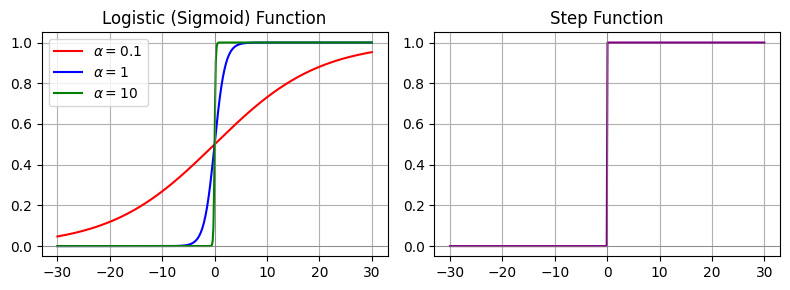

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def logistic(x, alpha=1.0):
    return 1 / (1 + np.exp(-alpha * x))

def step(x):
    return np.where(x > 0, 1, 0)

# Input values
x_vals = np.linspace(-30, 30, 400)

# Compute logistic values for different alphas
logistic_vals_01 = logistic(x_vals, alpha=0.1)
logistic_vals_1 = logistic(x_vals, alpha=1.0)
logistic_vals_10 = logistic(x_vals, alpha=10)

# Compute step function
step_vals = step(x_vals)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Logistic subplot with different alpha values
axs[0].plot(x_vals, logistic_vals_01, label=r'$\alpha=0.1$', color='red')
axs[0].plot(x_vals, logistic_vals_1, label=r'$\alpha=1$', color='blue')
axs[0].plot(x_vals, logistic_vals_10, label=r'$\alpha=10$', color='green')
axs[0].set_title("Logistic (Sigmoid) Function")
axs[0].legend()
axs[0].grid(True)
axs[0].axhline(0, color='gray', linewidth=0.5)
axs[0].axvline(0, color='gray', linewidth=0.5)

# Step function subplot
axs[1].plot(x_vals, step_vals, label="Step", color='purple')
axs[1].set_title("Step Function")
axs[1].grid(True)
axs[1].axhline(0, color='gray', linewidth=0.5)
axs[1].axvline(0, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()


In [1]:
import openml

# List all datasets and their properties
openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
dataset = openml.datasets.get_dataset(61)

# Get dataset by name
dataset = openml.datasets.get_dataset('Fashion-MNIST')

# Get the data itself as a dataframe (or otherwise)
X, y, _, _ = dataset.get_data(dataset_format="dataframe")

OpenMLServerError: Unexpected server error when calling https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0. Please contact the developers!
Status code: 502
<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>502 Proxy Error</title>
</head><body>
<h1>Proxy Error</h1>
<p>The proxy server received an invalid
response from an upstream server.<br />
The proxy server could not handle the request<p>Reason: <strong>Error reading from remote server</strong></p></p>
<hr>
<address>Apache/2.4.29 (Ubuntu) Server at www.openml.org Port 443</address>
</body></html>


In [2]:
def calculate_residuals(y_train, y_train_pred, y_val, y_val_pred):
    residuals_train = y_train - y_train_pred
    residuals_val = y_val - y_val_pred
    return residuals_train, residuals_val

    

In [9]:
import torch

def compute_class_weights(y_true: torch.Tensor) -> dict:
    """
    Compute class weights based on inverse frequency, normalized to sum to 1.
    Independent of dataset size.

    Parameters
    ----------
    y_true : torch.Tensor
        Tensor of true labels (binary or multi-class).

    Returns
    -------
    dict
        Dictionary mapping each class label to its normalized weight.
    """
    unique_classes, counts = torch.unique(y_true, return_counts=True)

    # Compute frequencies
    frequencies = counts.float() / counts.sum()

    # Inverse frequencies
    inv_freq = 1.0 / frequencies

    # Normalize inverse frequencies to sum to 1
    norm_weights = inv_freq / inv_freq.sum()

    # Convert to dictionary
    class_weight_dict = {int(cls): float(weight) for cls, weight in zip(unique_classes, norm_weights)}

    return class_weight_dict


In [11]:
a = torch.tensor([0,1,0,1,1,1,1 , 0 , 0, 1, 1, 1,1 ,1, 1])

compute_class_weights(a)

{0: 0.7333333492279053, 1: 0.2666666805744171}

In [3]:
def ensemble_predict(model, X, ms):
    
    prediction = model[0].predict(X)
    for i in range(1, len(model)):
        prediction = prediction + ms* model[i].predict(X)
    
    return prediction

In [4]:
def gp_boosting(X_train, y_train, X_val, y_val, n_iter, ms, gp_params):
    
    ensemble = [gp(X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, **gp_params)]
    
    for i in range(n_iter):
        
        y_train_pred = ensemble_predict(ensemble, X_train, ms)
        y_val_pred = ensemble_predict(ensemble, X_val, ms)
        y_residuals_train, y_residuals_val = calculate_residuals(y_train, y_train_pred, y_val, y_val_pred)
        
        new_learner = gp(X_train=X_train, y_train=y_residuals_train, X_test=X_val, y_test=y_residuals_val, **gp_params)
        
        ensemble.append(new_learner)
        
    return ensemble

In [5]:
gp_params1 = {'p_xo': 0.2, 'pop_size': 100, 'n_iter': 20, 'max_depth': 6, 'tree_constants': [-2,-1,-0.5,0.5,1,2], 'seed': 1}
booster1 = gp_boosting(X_train, y_train, X_val, y_val, 100, 0.2, gp_params=gp_params1)

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     dataset_1           |       0      |   14.11939525604248   |   14.084373474121094     |   0.03914165496826172  |      3           |
|     dataset_1           |       1      |   14.11939525604248   |   14.084373474121094     |   0.03905367851257324  |      3           |
|     dataset_1           |       2      |   13.674275398254395  |   13.629154205322266     |   0.037114620208740234 |      13          |
|     dataset_1           |       3      |   13.674275398254395  |   13.629154205322266     |   0.02099299430847168  |      13          |
|     dataset_1  

c:\Users\leond\OneDrive\Desktop\MasterThesis\slim\slim_gsgp\main_gp.py:148: UserWarning: No dataset name set. Using default value of dataset_1.
  warnings.warn("No dataset name set. Using default value of dataset_1.")


|     dataset_1           |       5      |   12.517067909240723  |   11.994671821594238     |   0.015491724014282227 |      19          |
|     dataset_1           |       6      |   12.515715599060059  |   11.9921293258667       |   0.03587055206298828  |      15          |
|     dataset_1           |       7      |   12.028214454650879  |   11.780181884765625     |   0.01404261589050293  |      19          |
|     dataset_1           |       8      |   11.94970989227295   |   11.693682670593262     |   0.016730308532714844 |      19          |
|     dataset_1           |       9      |   11.94448184967041   |   11.670761108398438     |   0.03278994560241699  |      19          |
|     dataset_1           |       10     |   11.94448184967041   |   11.670761108398438     |   0.03183603286743164  |      19          |
|     dataset_1           |       11     |   11.824519157409668  |   11.944905281066895     |   0.03665471076965332  |      25          |
|     dataset_1           |       

In [6]:
gp_params2 = {'p_xo': 0.2, 'pop_size': 100, 'n_iter': 20, 'max_depth': 6, 'tree_constants': [-2,-1,-0.5,0.5,1,2], 'seed': 2}
booster2 = gp_boosting(X_train, y_train, X_val, y_val, 100, 0.2, gp_params=gp_params2)

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     dataset_1           |       0      |   14.038907051086426  |   14.001823425292969     |   0.0711665153503418   |      3           |
|     dataset_1           |       1      |   12.617929458618164  |   12.535231590270996     |   0.04484081268310547  |      7           |
|     dataset_1           |       2      |   12.171060562133789  |   12.160685539245605     |   0.041570186614990234 |      5           |
|     dataset_1           |       3      |   12.171060562133789  |   12.160685539245605     |   0.04385232925415039  |      5           |
|     dataset_1  

In [8]:
print(r2_score(y_train, ensemble_predict(booster2, X_train, 0.2)))
print(r2_score(y_test, ensemble_predict(booster2, X_test, 0.2)))

0.09644861459851284
0.09360553703249941


In [9]:
from sklearn.linear_model import LinearRegression  
lr = LinearRegression()
lr.fit(X_train, y_train)
print(r2_score(y_train, lr.predict(X_train)))
print(r2_score(y_test, lr.predict(X_test)))

0.1656479835510254
0.15773195028305054


In [10]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_train, lr.predict(X_train)))
print(mean_squared_error(y_test, lr.predict(X_test)))

95.08515930175781
101.30331420898438


In [11]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=20, max_depth=3, learning_rate=0.1, validation_fraction=0.2, n_iter_no_change=3)
gb.fit(X_train, y_train)
print(r2_score(y_train, gb.predict(X_train)))
print(r2_score(y_test, gb.predict(X_test)))


0.5425791111037664
0.5411886271143427


In [ ]:

print(r2_score(y_test, predictions))

-0.002679477144073683


In [ ]:
# Compute and print the RMSE on the test set
print(float(rmse(y_true=y_test, y_pred=predictions)))

10.981653213500977


In [ ]:
y_train_res = y_train - final_tree1.predict(X_train)
y_val_res = y_val - final_tree1.predict(X_val)

In [ ]:
final_tree2 = gp(X_train=X_train, y_train=y_train_res,
                X_test=X_val, y_test=y_val_res, p_xo = 0.2,
                 pop_size=100, n_iter=2)

print(r2_score(y_train_res, final_tree2.predict(X_train)))

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     dataset_1           |       0      |   10.584206581115723  |   10.50875473022461      |   0.03069782257080078  |      5           |
|     dataset_1           |       1      |   10.584206581115723  |   10.50875473022461      |   0.015687227249145508 |      5           |
|     dataset_1           |       2      |   10.584206581115723  |   10.50875473022461      |   0.01966071128845215  |      5           |
0.008473687786882844


c:\Users\leond\OneDrive\Desktop\MasterThesis\slim\slim_gsgp\main_gp.py:148: UserWarning: No dataset name set. Using default value of dataset_1.
  warnings.warn("No dataset name set. Using default value of dataset_1.")


In [ ]:
print(r2_score(y_train, final_tree1.predict(X_train) + 0.2*final_tree2.predict(X_train)))

0.009149680758378076


In [ ]:
y_train_res = y_train - final_tree1.predict(X_train) - final_tree2.predict(X_train)
y_val_res = y_val - final_tree1.predict(X_val) - final_tree2.predict(X_val)

In [ ]:
final_tree3 = gp(X_train=X_train, y_train=y_train_res,
                X_test=X_val, y_test=y_val_res, p_xo = 0.2,
                pop_size=100, n_iter=50)

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     dataset_1           |       0      |   10.555161476135254  |   10.483696937561035     |   0.03277420997619629  |      5           |
|     dataset_1           |       1      |   10.555161476135254  |   10.483696937561035     |   0.003566265106201172 |      5           |
|     dataset_1           |       2      |   10.545053482055664  |   10.478705406188965     |   0.028417348861694336 |      9           |


c:\Users\leond\OneDrive\Desktop\MasterThesis\slim\slim_gsgp\main_gp.py:148: UserWarning: No dataset name set. Using default value of dataset_1.
  warnings.warn("No dataset name set. Using default value of dataset_1.")


|     dataset_1           |       3      |   10.545053482055664  |   10.478705406188965     |   0.017095327377319336 |      9           |
|     dataset_1           |       4      |   10.544862747192383  |   10.47348403930664      |   0.025582551956176758 |      7           |
|     dataset_1           |       5      |   10.544862747192383  |   10.47348403930664      |   0.02510690689086914  |      7           |
|     dataset_1           |       6      |   10.54106330871582   |   10.455854415893555     |   0.024209260940551758 |      11          |
|     dataset_1           |       7      |   10.54106330871582   |   10.455854415893555     |   0.017879009246826172 |      11          |
|     dataset_1           |       8      |   10.54106330871582   |   10.455854415893555     |   0.03480720520019531  |      11          |
|     dataset_1           |       9      |   10.522829055786133  |   10.434977531433105     |   0.048365116119384766 |      7           |
|     dataset_1           |       

In [ ]:
print(r2_score(y_train, final_tree1.predict(X_train) + 0.2*final_tree2.predict(X_train) + 0.2*final_tree3.predict(X_train)))

0.01865184168215339


In [ ]:
print(r2_score(y_train, final_tree1.predict(X_train) + 0.2*final_tree2.predict(X_train) + 0.2*final_tree3.predict(X_train)))

0.01865184168215339


In [91]:
import torch
import sys
import os

sys.path.insert(0, os.path.abspath(".."))  # Adds the parent directory to sys.path


from slim_gsgp.main_gp import gp  # import the slim_gsgp library
from slim_gsgp.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim_gsgp.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim_gsgp.utils.utils import train_test_split  # import the train-test split function

# Load the PPB dataset
X, y = load_ppb(X_y=True)



X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.5)



features = [f'x{i}' for i in range(X_train.shape[1])]
random_column_indices = torch.randperm(X.shape[1])[:X_train.shape[1]][:10]
mapping = {f'x{i}': features[idx] for i, idx in enumerate(random_column_indices)}




final_tree = gp(X_train=X_train[:, random_column_indices], y_train=y_train,
                X_test=X_val[:, random_column_indices], y_test=y_val,
                dataset_name='ppb', pop_size=20, n_iter=100)

# Show the best individual structure at the last generation
final_tree.print_tree_representation()

# Get the prediction of the best individual on the test set
predictions = final_tree.predict(X_test)

# Compute and print the RMSE on the test set
print(float(rmse(y_true=y_test, y_pred=predictions)))

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     ppb                 |       0      |   60.130374908447266  |   62.51374816894531      |   0.0                  |      3           |
|     ppb                 |       1      |   46.44997787475586   |   48.189517974853516     |   0.01564311981201172  |      3           |
|     ppb                 |       2      |   35.755615234375     |   37.96784973144531      |   0.0                  |      5           |
|     ppb                 |       3      |   34.381134033203125  |   34.04939270019531      |   0.01402735710144043  |      51          |
|     ppb        

NameError: name 'random_column_indices' is not defined

In [92]:
mapping

{'x0': 'x249',
 'x1': 'x174',
 'x2': 'x411',
 'x3': 'x349',
 'x4': 'x464',
 'x5': 'x235',
 'x6': 'x512',
 'x7': 'x538',
 'x8': 'x157',
 'x9': 'x380'}

In [93]:
final_tree.repr_

('multiply', ('add', 'x1', 'x1'), ('add', 'x7', 'x7'))

In [94]:
final_tree.predict(X_test)

tensor([1806.6177,  846.7712, 1200.5791,  673.5439,  577.9280,  804.6608,
         498.8332,  966.2940,  886.8480,  660.7216,  647.7904,  749.9760,
         658.2576, 1084.6796,  629.6160,  610.6100, 1018.1392,  747.3179,
        1054.5801,  975.2160,  805.2480,  511.2120,  996.8660,  668.0400,
         628.7952,  975.8640])

In [95]:
final_tree.predict(X_test[:, random_column_indices])

tensor([75.8320, 80.1436, 75.1838, 67.3774, 53.2332, 75.9467, 60.3557, 74.8422,
        70.1281, 68.1138, 58.1199, 75.9276, 70.8511, 75.2777, 65.9932, 66.4475,
        72.7551, 72.3819, 79.1864, 68.7499, 71.2135, 62.0150, 69.2798, 62.3526,
        53.1727, 75.8520])

In [96]:
def reverse_feature_names(model_tuple, reverse_mapping):
    if isinstance(model_tuple, tuple):
        # If it's a tuple, recursively process each element
        return tuple(reverse_feature_names(element, reverse_mapping) if isinstance(element, tuple) else reverse_mapping.get(element, element) for element in model_tuple)
    elif isinstance(model_tuple, str):
        # If it's a string (a feature name), replace using the reverse mapping
        return reverse_mapping.get(model_tuple, model_tuple)
    else:
        return model_tuple

In [97]:
a = reverse_feature_names(final_tree.repr_, mapping)
a

('multiply', ('add', 'x174', 'x174'), ('add', 'x538', 'x538'))

In [98]:
final_tree.TERMINALS 

{'x0': 0,
 'x1': 1,
 'x2': 2,
 'x3': 3,
 'x4': 4,
 'x5': 5,
 'x6': 6,
 'x7': 7,
 'x8': 8,
 'x9': 9}

In [99]:
final_tree.TERMINALS = {'x646': 646, 'x411':411}

In [100]:
final_tree.FUNCTIONS

{'add': {'function': <function torch._VariableFunctionsClass.add>, 'arity': 2},
 'subtract': {'function': <function torch._VariableFunctionsClass.sub>,
  'arity': 2},
 'multiply': {'function': <function torch._VariableFunctionsClass.mul>,
  'arity': 2},
 'divide': {'function': <function slim_gsgp.utils.utils.protected_div(x1, x2)>,
  'arity': 2}}

In [101]:
final_tree.repr_ = a
final_tree.predict(X_test)

TypeError: add(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
final_tree.repr_ = ('x0')
final_tree.predict(X_test)

tensor([ 23.,   5.,  70., 114.,  81.,  94., 108.,  15., 107.,  16., 104.,  71.,
         25.,  67.,  33.,  72., 126.,  19.,  38.,  50., 115., 121.,  46.,  83.,
        129.,  92.])

In [ ]:
final_tree.CONSTANTS

{'constant_2.0': <function slim_gsgp.main_gp.gp.<locals>.<dictcomp>.<lambda>(_, num=2.0)>,
 'constant_3.0': <function slim_gsgp.main_gp.gp.<locals>.<dictcomp>.<lambda>(_, num=3.0)>,
 'constant_4.0': <function slim_gsgp.main_gp.gp.<locals>.<dictcomp>.<lambda>(_, num=4.0)>,
 'constant_5.0': <function slim_gsgp.main_gp.gp.<locals>.<dictcomp>.<lambda>(_, num=5.0)>,
 'constant__1.0': <function slim_gsgp.main_gp.gp.<locals>.<dictcomp>.<lambda>(_, num=-1.0)>}

In [ ]:
final_tree.TERMINALS

{'x646': 646, 'x411': 411}

In [ ]:
final_tree.FUNCTIONS

{'add': {'function': <function torch._VariableFunctionsClass.add>, 'arity': 2},
 'subtract': {'function': <function torch._VariableFunctionsClass.sub>,
  'arity': 2},
 'multiply': {'function': <function torch._VariableFunctionsClass.mul>,
  'arity': 2},
 'divide': {'function': <function slim_gsgp.utils.utils.protected_div(x1, x2)>,
  'arity': 2}}

In [ ]:
X_test.shape[1]

626

In [ ]:
mapping

{'x0': 'x249', 'x1': 'x174', 'x2': 'x411', 'x3': 'x349'}

In [ ]:
import torch

# Original feature columns (for example, x1, x2, ..., x1000)
features = [f'x{i}' for i in range(1, 1001)]  # x1, x2, ..., x1000

# Subsampled feature indices (e.g., selecting x440, x550, x539, x464, x496)
subsampled_indices = torch.tensor([439, 549, 538, 463, 495])  # Corresponding to x440, x550, x539, x464, x496

# Create the mapping from the original features to the new names (x1, x2, ...)
feature_mapping = {features[idx]: f'x{i+1}' for i, idx in enumerate(subsampled_indices)}

# Reverse mapping: from new feature names (x1, x2, ...) to original features (x440, x550, ...)
reverse_mapping = {v: k for k, v in feature_mapping.items()}

# Model tuple with subsampled feature names (e.g., ('subtract', ('add', 'x440', ('add', 'x550', ('multiply', 'x539', 'x464'))), 'x496'))
model_tuple = ('subtract',
               ('add', '2', ('add', 'x1', ('multiply', 'x7', 'x464'))),
               'x496')

# Reverse the transformation recursively by using the reverse mapping
def reverse_feature_names(model_tuple, reverse_mapping):
    if isinstance(model_tuple, tuple):
        # If it's a tuple, recursively process each element
        return tuple(reverse_feature_names(element, reverse_mapping) if isinstance(element, tuple) else reverse_mapping.get(element, element) for element in model_tuple)
    elif isinstance(model_tuple, str):
        # If it's a string (a feature name), replace using the reverse mapping
        return reverse_mapping.get(model_tuple, model_tuple)
    else:
        return model_tuple

# Reverse the model tuple using the reverse_mapping
reversed_model = reverse_feature_names(model_tuple, reverse_mapping)

# Print the reversed model tuple
print("Original Model:", model_tuple)
print("Reversed Model:", reversed_model)


Original Model: ('subtract', ('add', '2', ('add', 'x1', ('multiply', 'x7', 'x464'))), 'x496')
Reversed Model: ('subtract', ('add', '2', ('add', 'x440', ('multiply', 'x7', 'x464'))), 'x496')


In [ ]:
import torch

# Original feature columns (x1, x2, ..., x100)
features = [f'x{i}' for i in range(0, 100)]  # x1, x2, ..., x100

# Subsampled feature indices (e.g., selecting x10, x30, x2)
subsampled_indices = torch.tensor([20, 29, 1])  # Corresponding to x10, x30, x2

# Create the mapping: from new x1, x2, x3 to original feature names
mapping = {f'x{i+1}': features[idx] for i, idx in enumerate(subsampled_indices)}

# Model tuple with subsampled feature names (e.g., ('multiply', 'x30', 'x2'))
model_tuple = ('multiply', 'x1', 'x2')

# Reverse the transformation:
# Use the mapping to replace the subsampled feature names with original ones
def reverse_feature_names(model_tuple, mapping):
    reversed_model = []
    
    for element in model_tuple:
        if isinstance(element, str) and element.startswith('x'):
            # Check if the feature is in the mapping and replace it
            reversed_model.append(mapping.get(element, element))
        else:
            reversed_model.append(element)
    
    return tuple(reversed_model)

# Reverse the model tuple
reversed_model = reverse_feature_names(model_tuple, mapping)

# Print the reversed model tuple
print("Original Model:", model_tuple)
print("Reversed Model:", reversed_model)


Original Model: ('multiply', 'x1', 'x2')
Reversed Model: ('multiply', 'x20', 'x29')


In [ ]:
X_val[13]

tensor([ 1.3000e+02,  2.5938e+02,  6.4800e+00,  2.4000e+01,  3.9590e+01,
         2.5530e+01,  4.0670e+01,  6.0000e-01,  9.9000e-01,  6.4000e-01,
         2.1400e+00,  4.0000e+01,  1.9000e+01,  4.1000e+01,  2.0000e+01,
         1.1000e+01,  2.5500e+01,  5.5000e-01,  2.0000e+00,  3.0000e+00,
         6.0000e+00,  1.4600e-01,  0.0000e+00,  0.0000e+00,  1.1000e+01,
         2.1000e+01,  1.6000e+01,  1.0000e+00,  2.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  2.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  2.0000e+00,  9.2000e+01,
         2.1600e+02,  1.0300e+02,  2.1400e+02,  1.1000e+01,  1.3118e+01,
         1.8690e+00,  1.9950e+00,  2.7600e-01,  4.0500e+01,  5.0000e+00,
         2.5000e+01,  8.3661e+01,  8.3368e+01,  2.9000e-01,  3.3060e+03,
         4.9930e+03,  3.2340e+03,  7.0870e+03,  1.9

In [ ]:
random_indices = torch.randperm(X.size(0))

# Select the subsample
subsampled_tensor = X[random_indices[:4]]

In [ ]:
subsampled_tensor

tensor([[5.0000e+00, 3.4144e+02, 7.1100e+00,  ..., 4.8840e+00, 1.9500e-01,
         2.9476e+01],
        [1.1800e+02, 2.3011e+02, 1.0000e+01,  ..., 3.6900e+00, 2.6400e-01,
         1.4522e+01],
        [4.4000e+01, 3.8944e+02, 8.1100e+00,  ..., 5.2670e+00, 1.8200e-01,
         3.3476e+01],
        [8.8000e+01, 4.1439e+02, 8.6300e+00,  ..., 5.1440e+00, 1.8400e-01,
         2.8557e+01]])

In [ ]:
import torch

# Create a 2D tensor (e.g., 5 samples, 10 features)
tensor = torch.arange(0, 50).view(5, 10)

# Define the number of rows and columns to subsample
num_rows = 3
num_columns = 4

random_row_indices = torch.randperm(tensor.size(0))[:num_rows]
random_column_indices = torch.randperm(tensor.size(1))[:num_columns]
subsampled_tensor = tensor[random_row_indices][:, random_column_indices]





print(subsampled_tensor)


tensor([[ 6,  2,  0,  1],
        [16, 12, 10, 11],
        [46, 42, 40, 41]])


In [ ]:
import torch


X = torch.arange(0, 50).view(5, 10)
y = torch.tensor([0, 1, 0, 1, 0])
num_rows = 3
num_columns = 4


random_row_indices = torch.randperm(X.size(0))[:num_rows]
random_column_indices = torch.randperm(X.size(1))[:num_columns]
subsampled_X = X[random_row_indices][:, random_column_indices]
subsampled_y = y[random_row_indices]



In [ ]:
random_column_indices

tensor([1, 3, 8, 7])

In [ ]:
subsampled_X
subsampled_y

tensor([1, 0, 1])

In [ ]:
from slim_gsgp.main_gsgp import gsgp  # import the slim_gsgp library
from slim_gsgp.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim_gsgp.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim_gsgp.utils.utils import train_test_split  # import the train-test split function


# Load the PPB dataset
X, y = load_ppb(X_y=True)


X = torch.rand(1000, 2)
y = torch.round(( 3*X[:, 0] + 10*X[:, 1]) * 0.1 )



# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.4)

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.5)

# Apply the Standard GSGP algorithm
final_tree = gsgp(X_train=X_train, y_train=y_train,
                  X_test=X_val, y_test=y_val, p_xo=0.00,
                  dataset_name='ppb', pop_size=100, n_iter=100, log_path='log/test.csv',
                  reconstruct=True, ms_lower=0, ms_upper=1)

# Get the prediction of the best individual on the test set
predictions = final_tree.predict(X_test)

# Compute and print the RMSE on the test set
print(float(rmse(y_true=y_test, y_pred=predictions)))

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     ppb                 |       0      |   0.4094386100769043  |   0.4401421546936035     |   0.1175069808959961   |      7           |
|     ppb                 |       1      |   0.3711094856262207  |   0.39981189370155334    |   0.05400824546813965  |      21          |
|     ppb                 |       2      |   0.3711094856262207  |   0.39981189370155334    |   0.0509946346282959   |      21          |
|     ppb                 |       3      |   0.361844003200531   |   0.3857569694519043     |   0.03437542915344238  |      51          |
|     ppb        

In [9]:
from sklearn.metrics import accuracy_score, r2_score, f1_score, roc_auc_score

predictions = torch.round(torch.sigmoid(predictions))
def print_scores(y_test, predictions):
    print("Roc Score:", roc_auc_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, torch.round(predictions)))
    print("Accuracy Score:", accuracy_score(y_test, torch.round(predictions)))


print_scores(y_test, predictions)

Roc Score: 1.0
F1 Score: 1.0
Accuracy Score: 1.0


In [15]:
from slim_gsgp.main_slim import slim  # import the slim_gsgp library
from slim_gsgp.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim_gsgp.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim_gsgp.utils.utils import train_test_split  # import the train-test split function

final_tree = slim(X_train=X_train, y_train=y_train,
                  X_test=X_val, y_test=y_val,
                  dataset_name='ppb', slim_version='SLIM+SIG2', pop_size=100, n_iter=200,
                  ms_lower=0, ms_upper=1, p_inflate=0.5)


final_tree.print_tree_representation()

# Get the prediction of the best individual on the test set
predictions = final_tree.predict(X_test)

# Compute and print the RMSE on the test set
print(float(rmse(y_true=y_test, y_pred=predictions)))

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     ppb                 |       0      |   0.4104837477207184  |   0.43212756514549255    |   0.02074432373046875  |      5           |
|     ppb                 |       1      |   0.39050939679145813 |   0.42522403597831726    |   0.036963462829589844 |      20          |
|     ppb                 |       2      |   0.39050939679145813 |   0.42522403597831726    |   0.029120922088623047 |      20          |
|     ppb                 |       3      |   0.38287675380706787 |   0.40183916687965393    |   0.03474926948547363  |      62          |
|     ppb        

In [7]:
predictions = torch.round(torch.sigmoid(predictions))
print_scores(y_test, predictions)

R2 Score: 1.0
F1 Score: 1.0
Accuracy Score: 1.0


In [8]:
from slim_gsgp.main_slim import slim  # import the slim_gsgp library
from slim_gsgp.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim_gsgp.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim_gsgp.utils.utils import train_test_split  # import the train-test split function

final_tree = slim(X_train=X_train, y_train=y_train,
                  X_test=X_val, y_test=y_val,
                  dataset_name='ppb', slim_version='SLIM+SIG2', pop_size=100, n_iter=200, minimization=False, fitness_function='f1_score',
                  ms_lower=0, ms_upper=1, p_inflate=0.5)


final_tree.print_tree_representation()

# Get the prediction of the best individual on the test set
predictions = final_tree.predict(X_test)

# Compute and print the RMSE on the test set
print(float(rmse(y_true=y_test, y_pred=predictions)))

tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.) tensor(0.) tensor(0.) tensor(367.) tensor(0.)
tensor(0.) tensor(0.) tensor(0.) tensor(367.) tensor(0.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tensor(0.6117) tensor(1.) tensor(233.) tensor(0.) tensor(367.)
tens

In [ ]:
from sklearn.metrics import accuracy_score, r2_score, f1_score, roc_auc_score